In [ ]:
# !unzip -uq '/content/drive/My Drive/Python/Recommendation/tmdb_5000_credits.csv.zip' -d '/content/drive/My Drive/Python/Recommendation'
# !unzip -uq '/content/drive/My Drive/Python/Recommendation/tmdb_5000_movies.csv.zip' -d '/content/drive/My Drive/Python/Recommendation'

In [1]:
import numpy as np
import pandas as pd
credits = pd.read_csv('/content/drive/My Drive/Python/Recommendation/input/tmdb_5000_credits.csv')
movies = pd.read_csv('/content/drive/My Drive/Python/Recommendation/input/tmdb_5000_movies.csv')

In [2]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [3]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [59]:
credits.columns = ['id','title','cast','crew']
movies1 = movies.merge(credits, on='id')

In [65]:
# movies1['crew'][0]

### Demographic Filtering
- weighted rating (WR) =  
              (v/(v+m))*R + 
              (m/(v+m))*C


*   v: # of votes for the movie 
*   m: the minimum votes required to be listed
*   R: the avg rating of the movie
*   C: the mean vote across the whole dataset (on a scale of 10)





In [6]:
C = movies1['vote_average'].mean()
C

6.092171559442011

In [7]:
m = movies1['vote_count'].quantile(0.9)
m
# which means, only the movies having at least 1838 votes will be used for feature selection.

1838.4000000000015

In [8]:
movies2 = movies1.copy().loc[movies1['vote_count'] >= m]
movies2.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [9]:
movies2.shape
# there are 481 movies which qualify to be in the list.

(481, 23)

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# define a new feature 'score'
movies2['score'] = movies2.apply(weighted_rating, axis=1)
movies2.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew,score
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.050669


In [ ]:
movies2 = movies2.sort_values('score', ascending=False)
movies2.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,tile,vote_average,vote_count,cast,crew,score
1881,25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",NaN,278,"[{""id"": 378, ""name"": ""prison""}, {""id"": 417, ""n...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,"[{""name"": ""Castle Rock Entertainment"", ""id"": 97}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-23,28341469,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,8.5,8205,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ...","[{""credit_id"": ""52fe4231c3a36847f800b153"", ""de...",8.059258
662,63000000,"[{""id"": 18, ""name"": ""Drama""}]",http://www.foxmovies.com/movies/fight-club,550,"[{""id"": 825, ""name"": ""support group""}, {""id"": ...",en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,146.757391,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",1999-10-15,100853753,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mischief. Mayhem. Soap.,Fight Club,8.3,9413,"[{""cast_id"": 4, ""character"": ""The Narrator"", ""...","[{""credit_id"": ""55731b8192514111610027d7"", ""de...",7.939256


In [ ]:
# movies2 = movies2.drop(columns=['title_y'])
movies2 = movies2.rename(columns={'title_x':'title'})
movies2.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,tile,vote_average,vote_count,cast,crew,score
1881,25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",NaN,278,"[{""id"": 378, ""name"": ""prison""}, {""id"": 417, ""n...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,"[{""name"": ""Castle Rock Entertainment"", ""id"": 97}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-23,28341469,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,8.5,8205,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ...","[{""credit_id"": ""52fe4231c3a36847f800b153"", ""de...",8.059258


Text(0.5, 1.0, 'Popular Movies')

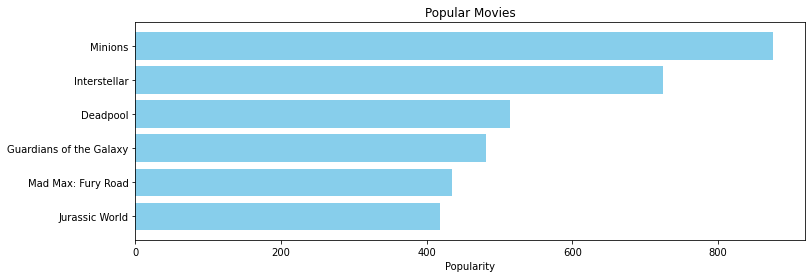

In [ ]:
pop= movies2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['original_title'].head(6),
         pop['popularity'].head(6), 
         align='center',
         color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

### Content Based Filtering

User A who likes Scientific Movie A will like other Scientific movies.

#### Description-based recommendation

In [38]:
movies1['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [15]:
movies1.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [12]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
movies1['overview'] = movies1['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies1['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

over 20K words were used to decribe the 4800 movies' contents.

In [13]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [37]:
# cosine_sim[0]

array([1., 0., 0., ..., 0., 0., 0.])

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. 

1.   We need a reverse mapping of movie titles and DataFrame indices. That's to say, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title


In [35]:
#Construct a reverse map of indices and movie titles
# indices = pd.Series(movies1.index, index=movies1['title_x']).drop_duplicates()

In [34]:
# indices

In [33]:
# indices['Avatar']

In [ ]:
# sim_scores = list(enumerate(cosine_sim[0]))
# sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
# sim_scores

In [21]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies1['title_x'].iloc[movie_indices]

In [27]:
get_recommendations('The Dark Knight')

3                         The Dark Knight Rises
428                              Batman Returns
3854    Batman: The Dark Knight Returns, Part 2
299                              Batman Forever
1359                                     Batman
119                               Batman Begins
1181                                        JFK
9            Batman v Superman: Dawn of Justice
2507                                  Slow Burn
210                              Batman & Robin
Name: title_x, dtype: object

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

#### Credits, Genres and Keywords Based Recommendation

We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

1. From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringfield" lists , we need to convert it into a safe and usable structure

In [72]:
# Parse the string features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies1[feature] = movies1[feature].apply(literal_eval)

In [71]:
# movies1.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


2. Prepare functions to extract the required information from each feature.

In [73]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [74]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return the first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [75]:
# Define new director, cast, genres and keywords features that are in a suitable form.
movies1['director'] = movies1['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies1[feature] = movies1[feature].apply(get_list)

In [76]:
# Print the new features of the first 3 films
movies1[['title_x', 'cast', 'director', 'keywords', 'genres']].head(3)

,title_x,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


3. convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [77]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''


In [78]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies1[feature] = movies1[feature].apply(clean_data)

We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [80]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies1['soup'] = movies1.apply(create_soup, axis=1)

In [81]:
movies1['soup']

0       cultureclash future spacewar samworthington zo...
1       ocean drugabuse exoticisland johnnydepp orland...
2       spy basedonnovel secretagent danielcraig chris...
3       dccomics crimefighter terrorist christianbale ...
4       basedonnovel mars medallion taylorkitsch lynnc...
                              ...                        
4798    unitedstates–mexicobarrier legs arms carlosgal...
4799     edwardburns kerrybishé marshadietlein edwardb...
4800    date loveatfirstsight narration ericmabius kri...
4801       danielhenney elizacoupe billpaxton danielhsia 
4802    obsession camcorder crush drewbarrymore brianh...
Name: soup, Length: 4803, dtype: object

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [82]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies1['soup'])

In [83]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [84]:
# Reset index of our main DataFrame and construct reverse mapping as before
movies1 = movies1.reset_index()
indices = pd.Series(movies1.index, index=movies1['title_x'])

We can now reuse our get_recommendations() function by passing in the new cosine_sim2 matrix as your second argument.

In [85]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title_x, dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

### Collaborative Filtering


In [87]:
ratings = pd.read_csv('/content/drive/My Drive/Python/Recommendation/input/ratings_small.csv')

In [89]:
!pip install surprise

     |████████████████████████████████| 11.8MB 6.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1646934 sha256=d69c58567ac2b7daba4881344905326e2af8c41dc94b35128239674783e5a371
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [110]:
from surprise import Reader, Dataset, SVD, accuracy  # SVD: singular value decomposition (SVD)
from surprise.model_selection import cross_validate, train_test_split

reader = Reader(rating_scale=(1,5))
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [96]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=0)
# data
# trainset.n_users
# trainset.n_items

In [107]:
model = SVD(n_factors=30) #n_factors: The number of factors. Default is `100`.
                          #100个隐含特征是指，原本4803 * n 的矩阵会被拆分成4803 *100和 100*n 的两个矩阵乘积
                          #n_factors值可以任意指定只要不超过n 即可，但是设置不同的值将会拟合出不同的模型，需要选择使结果较优的值。
model.fit(trainset)

In [ ]:
# model.pu.shape # (943, 100)
# model.qi.shape # (596, 100)

In [ ]:
# a_user = "User 196"
# a_product = "Toy Story (1995)"
# model.predict(a_user, a_product)

In [108]:
algo = SVD()
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [111]:
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8888


0.8888012834883923

In [112]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8890  0.8998  0.9002  0.9052  0.8888  0.8966  0.0066  
MAE (testset)     0.6872  0.6911  0.6909  0.6979  0.6865  0.6907  0.0040  
Fit time          4.92    4.86    4.97    4.89    5.01    4.93    0.05    
Test time         0.15    0.15    0.31    0.14    0.31    0.21    0.08    


{'fit_time': (4.923842191696167,
  4.861158132553101,
  4.967863082885742,
  4.885015249252319,
  5.011767864227295),
 'test_mae': array([0.6871578 , 0.69105443, 0.69092083, 0.69785585, 0.6865419 ]),
 'test_rmse': array([0.88904316, 0.89977745, 0.9001559 , 0.90524367, 0.88883646]),
 'test_time': (0.149888277053833,
  0.1479017734527588,
  0.3070712089538574,
  0.14431142807006836,
  0.30649232864379883)}

In [119]:
# ratings[ratings['userId'] == 1]

In [113]:
argo.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.8240483344481273, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 2.618. 

*   This recommender system doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.


In [126]:
top_n = get_top_n(predictions, n=10)
# top_n.items

# # Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

<function defaultdict.items>

In [116]:
# from collections import defaultdict

# from surprise import SVD
# from surprise import Dataset


# def get_top_n(predictions, n=10):
#     '''
#     Return the top-N recommendation for each user from a set of predictions.

#     Args:
#         predictions(list of Prediction objects): The list of predictions, as
#             returned by the test method of an algorithm.
#         n(int): The number of recommendation to output for each user. Default
#             is 10.

#     Returns:
#     A dict where keys are user (raw) ids and values are lists of tuples:
#         [(raw item id, rating estimation), ...] of size n.
#     '''

#     # First map the predictions to each user
#     top_n = defaultdict(list)
#     for uid, iid, true_r, est, _ in predictions:
#         top_n[uid].append((iid, est))

#     # Then sort the predictions for each user and retrieve the k highest ones.
#     for uid, user_ratings in top_n.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]

#     return top_n


In [130]:

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    # print(pd.DataFrame({'userID': uid,
    #                     'movieID': [iid for (iid, _) in user_ratings]}))

501 [745, 318, 2542, 58559, 1148, 48516, 1213, 1203, 72226, 2762]
608 [1219, 2300, 1228, 2997, 2064, 111, 1089, 1961, 608, 2186]
648 [1274, 4011, 1466, 3481, 293, 1246, 27773, 97, 45950, 7034]
592 [2571, 1148, 1197, 1214, 3635, 1580, 110, 2355, 2096, 3510]
381 [1200, 3462, 356, 2762, 1270, 4814, 2856, 2916, 4022, 2671]
382 [899, 2571, 1197, 4226, 4306, 1393, 5064, 86882, 2125, 6385]
390 [260, 541, 778, 2019, 296, 17, 32, 7, 21, 548]
217 [5816, 1220, 110, 3147, 3578, 2599, 5500, 16, 4306, 2115]
615 [858, 260, 296, 99114, 68157, 1193, 87232, 1201, 778, 48516]
285 [858, 223, 1198, 1197, 2194, 1079, 296, 1073, 2918, 1213]
73 [608, 56367, 2762, 1060, 81591, 78499, 260, 1090, 46578, 1193]
564 [924, 296, 2947, 1225, 32, 1247, 926, 1273, 3044, 1361]
597 [1136, 2064, 1270, 1148, 1267, 2076, 1240, 1077, 908, 1252]
15 [1136, 1260, 1196, 2959, 1270, 3730, 2028, 953, 904, 6620]
227 [2273, 2321, 2354, 2335, 2384, 2340]
48 [5995, 2324, 6016, 4878, 501, 593, 1222, 1270, 68237, 78499]
190 [2997, 3114, 

In [125]:
ratings[ratings['userId'] == 23]

,userId,movieId,rating,timestamp
4008,23,1,3.0,1148729853
4009,23,6,3.5,1148730128
4010,23,11,3.5,1166728170
4011,23,16,4.0,1148672550
4012,23,19,2.0,1148669114
...,...,...,...,...
4729,23,44204,4.0,1148670935
4730,23,45186,3.5,1148672962
4731,23,45447,1.5,1149867891
4732,23,45722,2.5,1166728253


References:


*   https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
*   https://www.cnblogs.com/bjwu/p/9358777.html
*   https://www.cnblogs.com/bjwu/p/9358777.html
*   https://juejin.im/post/5b1108bae51d4506c7666cac



